<a href="https://colab.research.google.com/github/Ambuj-Bhandari/First-ML-Project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

In [ ]:
im_width = 256
im_height = 256

In [ ]:
image_filenames_train = []

# creating a list of all files containing the word 'mask'
# in Local Machine
# mask_files = glob('../../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

# in Kaggle
mask_files = glob('/content/drive/MyDrive/Colab Notebooks/new/Data/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)

['/content/drive/MyDrive/Colab Notebooks/new/Data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_17.tif', '/content/drive/MyDrive/Colab Notebooks/new/Data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_16.tif', '/content/drive/MyDrive/Colab Notebooks/new/Data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_1.tif', '/content/drive/MyDrive/Colab Notebooks/new/Data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_13.tif', '/content/drive/MyDrive/Colab Notebooks/new/Data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_11.tif', '/content/drive/MyDrive/Colab Notebooks/new/Data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_14.tif', '/content/drive/MyDrive/Colab Notebooks/new/Data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_12.tif', '/content/drive/MyDrive/Colab Notebooks/new/Data/lgg-mri-segmentation

3933

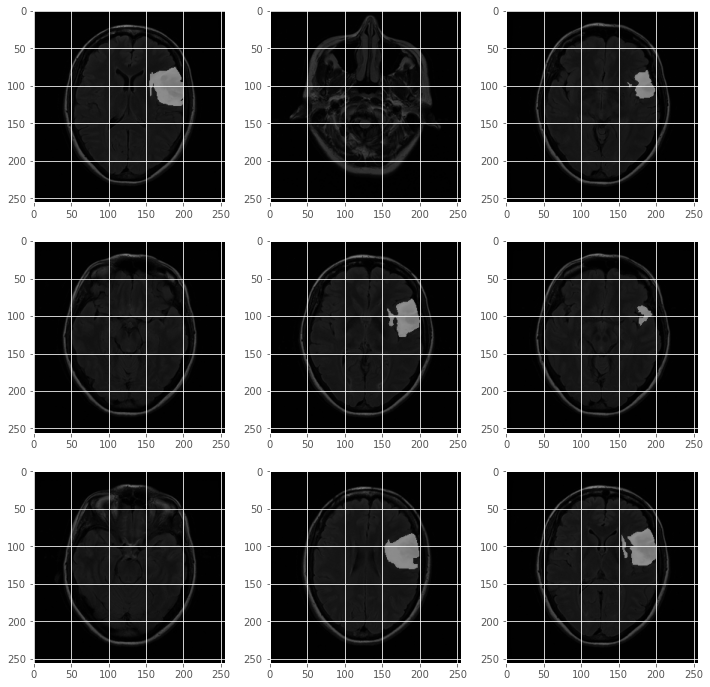

In [ ]:
plot_from_img_path(3, 3 , image_filenames_train, mask_files )

In [ ]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2831, 2)
(394, 2)
(708, 2)


In [ ]:
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [ ]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [ ]:
model = unet()
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f9fb05e7cd0>>

In [17]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=None,decay=decay_rate,amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)


Found 2831 validated image filenames.
Found 2831 validated image filenames.
Epoch 1/10
89/88 [==============================] - ETA: -7s - loss: -0.0697 - binary_accuracy: 0.8369 - iou: 0.0365 - dice_coefficients: 0.0698Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02755, saving model to unet.hdf5
88/88 [==============================] - 1709s 19s/step - loss: -0.0697 - binary_accuracy: 0.8369 - iou: 0.0365 - dice_coefficients: 0.0698 - val_loss: -0.0276 - val_binary_accuracy: 0.1656 - val_iou: 0.0138 - val_dice_coefficients: 0.0270
Epoch 2/10
89/88 [==============================] - ETA: 0s - loss: -0.1100 - binary_accuracy: 0.9656 - iou: 0.0587 - dice_coefficients: 0.1099
Epoch 2: val_loss did not improve from -0.02755
88/88 [==============================] - 151s 2s/step - loss: -0.1100 - binary_accuracy: 0.9656 - iou: 0.0587 - dice_coefficients: 0.1099 - val_loss: -0.0236 - val_binary_accuracy: 0.0695 - val_iou:

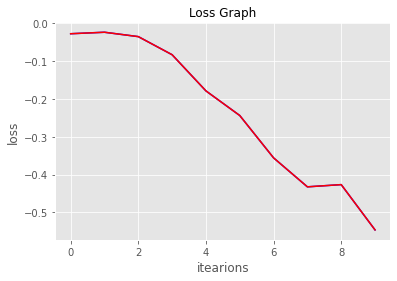

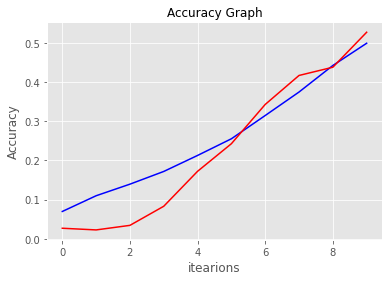

In [19]:
history_post=history.history
list_trainDicecoeff=history_post['dice_coefficients']
list_test_dicecoeff=history_post['val_dice_coefficients']

train_jacc=history_post['iou']
test_jacc=history_post['val_iou']

train_loss=history_post['loss']
test_loss=history_post['val_loss']

plt.figure(1)
plt.plot(test_loss,'b-')
plt.plot(test_loss,'r-')

plt.xlabel('itearions')
plt.ylabel('loss')
plt.title('Loss Graph',fontsize=12)

plt.figure(2)
plt.plot(list_trainDicecoeff,'b-')
plt.plot(list_test_dicecoeff,'r-')

plt.xlabel('itearions')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph',fontsize=12)
plt.show()


In [29]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients': dice_coefficients  })

In [31]:
test_gen=train_generator(df_test,BATCH_SIZE,dict(),target_size=(im_height,im_width))
results=model.evaluate(test_gen,steps=len(df_test)/BATCH_SIZE)

print("Test Loss: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficient: ",results[2])

Found 394 validated image filenames.
Found 394 validated image filenames.
12/12 [==============================] - 160s 14s/step - loss: -0.5466 - binary_accuracy: 0.9958 - iou: 0.3863 - dice_coefficients: 0.5527
Test Loss:  -0.5465627312660217
Test IOU:  0.995765209197998
Test Dice Coefficient:  0.3862888514995575


1/1 [==============================] - 0s 18ms/step


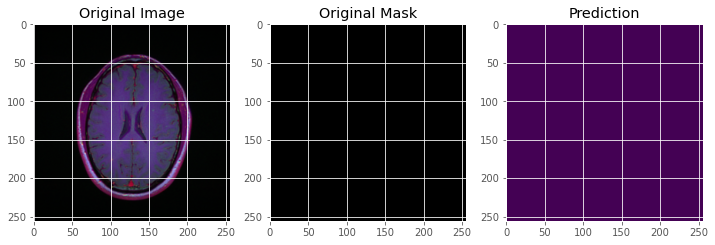

1/1 [==============================] - 0s 18ms/step


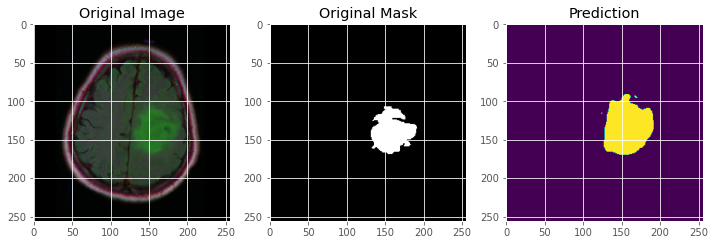

1/1 [==============================] - 0s 19ms/step


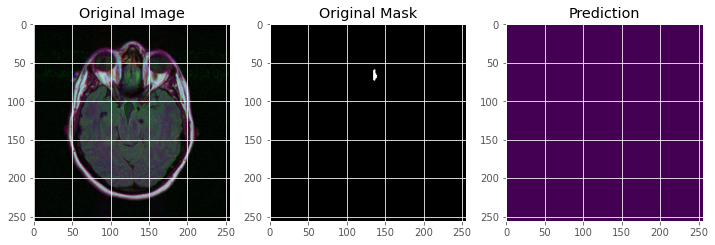

1/1 [==============================] - 0s 17ms/step


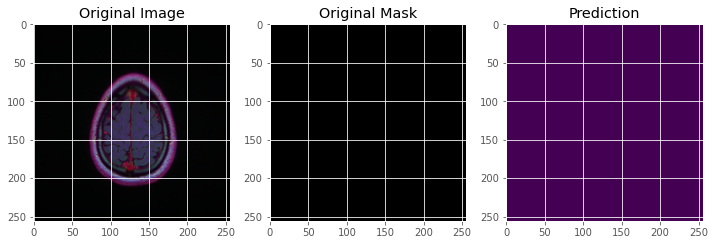

1/1 [==============================] - 0s 18ms/step


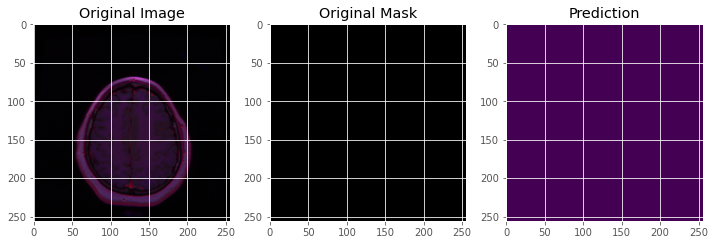

1/1 [==============================] - 0s 21ms/step


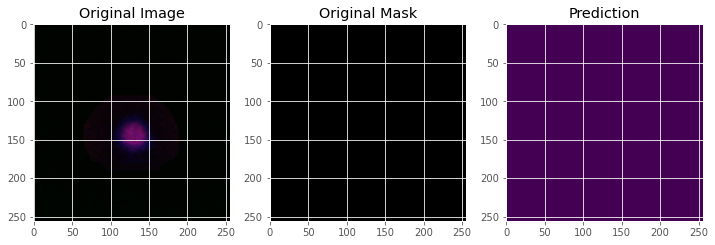

1/1 [==============================] - 0s 18ms/step


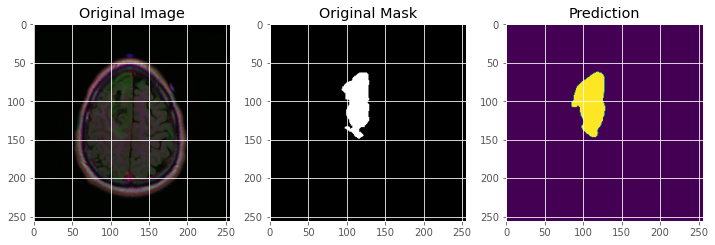

1/1 [==============================] - 0s 21ms/step


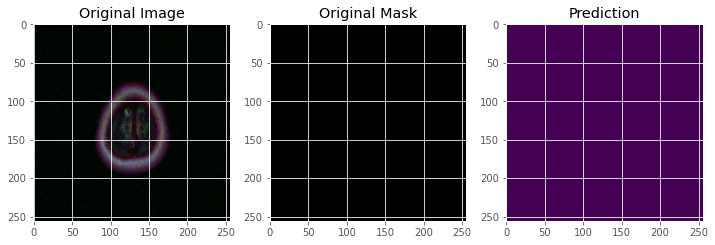

1/1 [==============================] - 0s 20ms/step


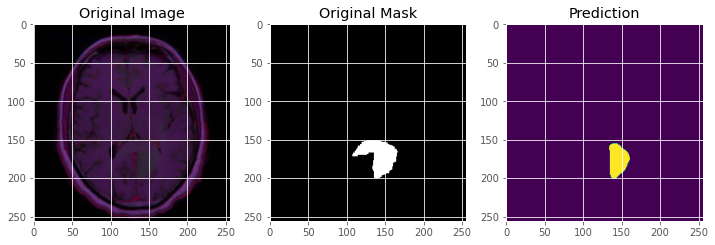

1/1 [==============================] - 0s 20ms/step


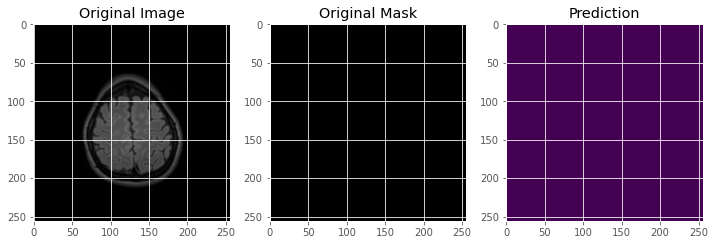

1/1 [==============================] - 0s 17ms/step


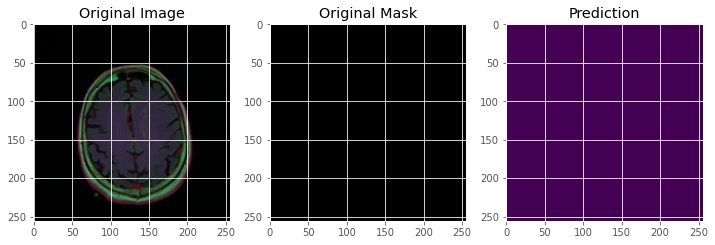

1/1 [==============================] - 0s 19ms/step


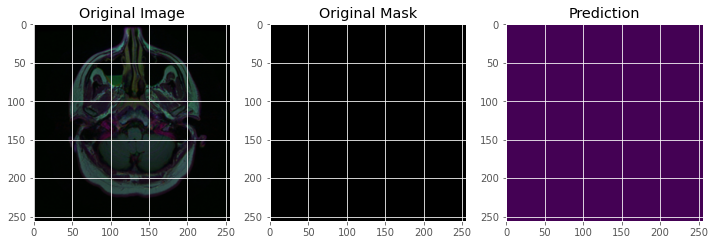

1/1 [==============================] - 0s 18ms/step


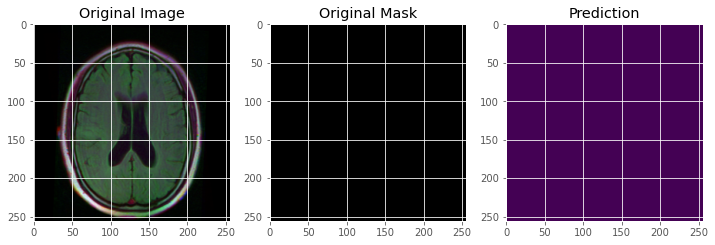

1/1 [==============================] - 0s 18ms/step


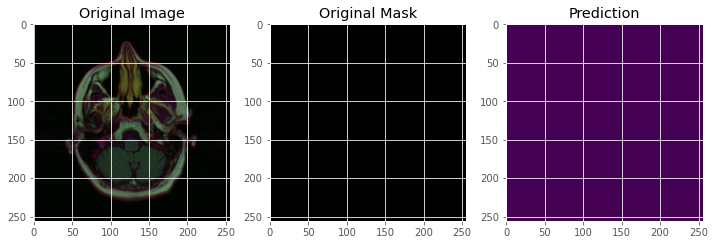

1/1 [==============================] - 0s 17ms/step


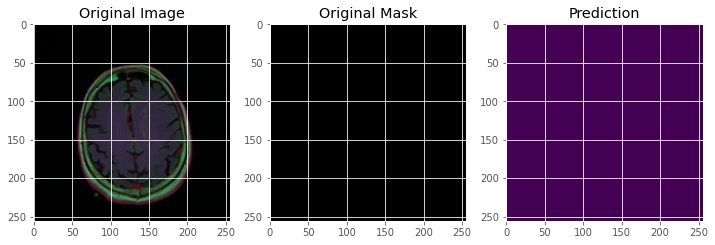

1/1 [==============================] - 0s 18ms/step


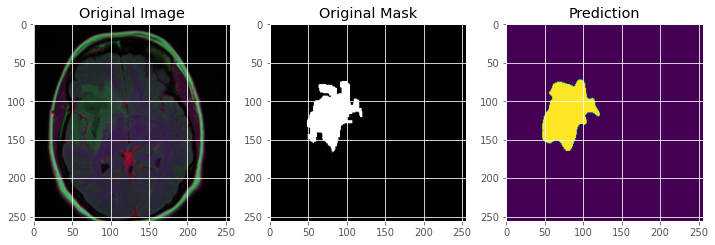

1/1 [==============================] - 0s 20ms/step


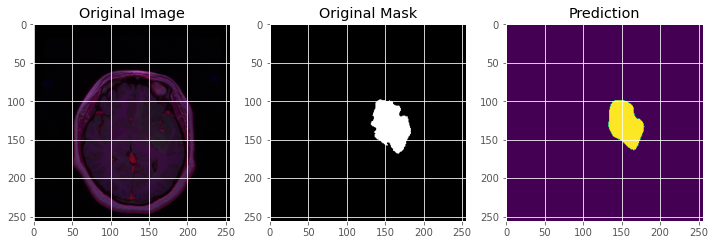

1/1 [==============================] - 0s 20ms/step


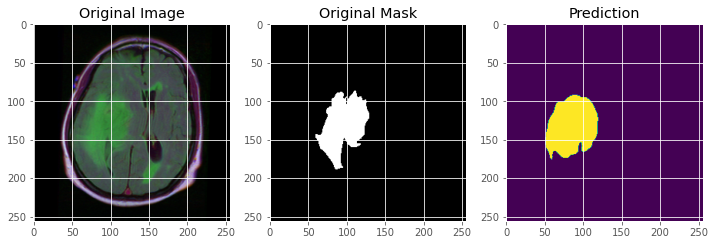

1/1 [==============================] - 0s 20ms/step


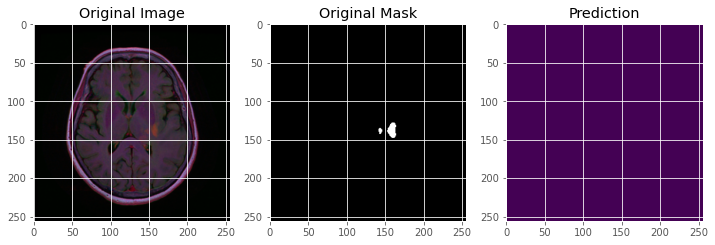

1/1 [==============================] - 0s 17ms/step


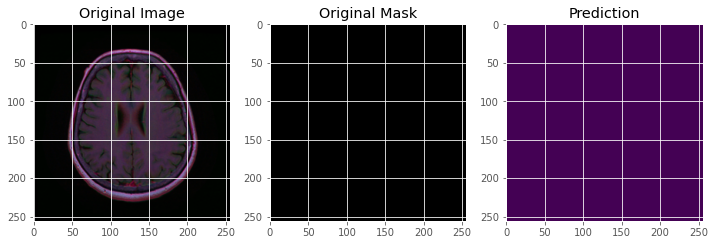

In [36]:
for i in range(20):
  index=np.random.randint(1,len(df_test.index))
  img=cv2.imread(df_test['image_filenames_train'].iloc[index])
  img=cv2.resize(img,(im_height,im_width))
  img=img/255

  img=img[np.newaxis,:,:,:]
  predic=model.predict(img)
  plt.figure(figsize=(12,12))

  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(img))
  plt.title('Original Image')

  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
  plt.title('Original Mask')

  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(predic)>0.5)
  plt.title('Prediction')
  plt.show()